In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

MEMORY = 4*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

2023-03-02 12:27:27.508124: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-02 12:27:27.695221: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-02 12:27:28.435149: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /end/home/rh2310/lib:/end/soft/Linux_2.6_64/lib::/end/home/rh2310/.conda/envs/tensorflo

1 Physical GPUs, 1 Logical GPUs


2023-03-02 12:27:29.957351: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-02 12:27:30.456919: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4096 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:e3:00.0, compute capability: 8.6


In [2]:
from local_utils import *

In [3]:
import pandas as pd
df_params = pd.read_pickle("../../bacterialcolony_dataset3/turing_df_circuit2_variant1_1000000parametersets.pkl")

In [4]:
df_params.head()

DA     DB    bA    bB    bC    bD    bE    bF          VA          VB  \
404   1.0  0.001  0.01  0.01  0.01  0.01  0.01  0.01  615.268976   73.210081   
2726  1.0  0.001  0.01  0.01  0.01  0.01  0.01  0.01  228.017071   94.502643   
3508  1.0  0.001  0.01  0.01  0.01  0.01  0.01  0.01   23.538028  320.885489   
7516  1.0  0.001  0.01  0.01  0.01  0.01  0.01  0.01   16.205693   83.166774   
7883  1.0  0.001  0.01  0.01  0.01  0.01  0.01  0.01   85.164519  738.495294   

      ...  nfe  nee  neb  nce ss_n  \
404   ...  4.0  4.0  4.0  1.0  2.0   
2726  ...  4.0  4.0  4.0  1.0  2.0   
3508  ...  4.0  4.0  4.0  1.0  3.0   
7516  ...  4.0  4.0  4.0  1.0  1.0   
7883  ...  4.0  4.0  4.0  1.0  2.0   

                                                ss_list       ss_class  \
404   [0.1997, 0.039, 10.9848, 104.771, 244.7529, 3....  stable spiral   
2726  [83.3645, 0.276, 12736.8586, 66.0485, 579.5646...  stable spiral   
3508  [6.9465, 0.1825, 57.5198, 3.3825, 131.0374, 1....  stable spiral   
7516  [1.7525, 0.2247, 908.552, 10.6864, 225.1614, 2...  stable spiral   
7883  [2.8165, 0.0136, 82.5102, 2.7508, 154.2711, 3....  stable spiral   

              system_class              maxeig complex_dispersion  
404   turing I oscillatory  0.004898+0.036487j               True  
2726  turing I oscillatory  0.000114+0.002647j               True  
3508  turing I oscillatory  0.001639+0.132134j               True  
7516  turing I oscillatory  0.000652+0.003066j               True  
7883  turing I oscillatory  0.001346+0.016362j               True  

[5 rows x 36 columns]

In [5]:
import pickle

with open('../../bacterialcolony_dataset3/2Dfinal_circuit2_variant1_bc1.7_ca_ID546780_L8_J160_T125_N2500.pkl', 'rb') as f:
    ds_1 = pickle.load(f)
    
with open('../../bacterialcolony_dataset/caMask_seed1_pdivision0.5_L10_J150_T120_N1200.pkl', 'rb') as f:
    mask = pickle.load(f)


In [6]:
ID = 546780
L = 8
data = np.array(ds_1)[:, :, :, np.newaxis]
nodes_n = data.shape[0]
node_names = ["A", "B", "C", "D", "E", "F"]
x_size = data.shape[1]
y_size = data.shape[2]
T=1
indices_all = np.arange(0, x_size*y_size*T, 1).reshape((T, x_size,y_size))
dxdy = x_size*y_size/L**2
N = x_size*y_size    
t_star = np.arange(T, T+1)

##########################
# select a subset of data
#t_star = t_star[-4:]
#T = len(t_star)
#data = data[:, :, :, -4::]

x_slice = slice(65, 100, 1)
y_slice = slice(65, 100, 1)

#data = data[:, x_slice, y_slice, np.newaxis]
#x_size = data.shape[1]
#y_size = data.shape[2]
#T = 1#data.shape[3]



indices_sub = indices_all[:, x_slice, y_slice]
block_x = indices_sub.shape[1]
block_y = indices_sub.shape[2]
block_size = indices_sub.shape[1]*indices_sub.shape[2]


maxs = np.array([np.max(data[i, :, :, :]) for i in range(data.shape[0])])
mins = np.array([np.min(data[i, :, :, :]) for i in range(data.shape[0])])

In [7]:
df_params.loc[ID,:]

DA                                                                  1.0
DB                                                                0.001
bA                                                                 0.01
bB                                                                 0.01
bC                                                                 0.01
bD                                                                 0.01
bE                                                                 0.01
bF                                                                 0.01
VA                                                            46.733347
VB                                                           134.697819
VC                                                            53.677758
VD                                                            44.231763
VE                                                            943.26562
VF                                                           605

In [8]:
def create_dataset_multi_nodes(
    data,
    t_star,
    N,
    T,
    L,
    training_data_size,
    pde_data_size,    
    signal_to_noise=0,
    shuffle=True,
    derivatives=None,
    idx_data=None,
):
    x_size = data.shape[1]
    y_size = data.shape[2]
    x_domain = L * np.linspace(0, 1, x_size)
    y_domain = L * np.linspace(0, 1, y_size)

    X, Y = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
    XX = np.tile(X.flatten(), T)  # N x T
    YY = np.tile(Y.flatten(), T)  # N x T
    TT = np.repeat(t_star[-T:], N)  # T x N

    #UU = np.einsum("cijk->ckij", data[:, :, :, -T:])
    UU = np.einsum("cxyk->ckxy", data[:, :, :, -T:])
    UU = np.array([UU[i, :, :, :].flatten() for i in range(UU.shape[0])])  # c , N x T
    
    if derivatives is not None:
        dds = np.array([[np.einsum("ijk->kij", d[i, :, :, -T:]).flatten() for d in derivatives]
               for i in range(derivatives[0].shape[0])
              ])                  
    ##########################################
    # Including noise
    if signal_to_noise > 0:
        signal_amp_u = (np.max(UU) - np.min(UU)) / 2.0
        sigma_u = signal_amp_u * signal_to_noise
    # Observed data
    if idx_data is None:
        if shuffle:
            idx_data = np.random.choice(N * T, training_data_size, replace=False)
        else:
            idx_data = list(range(training_data_size))
    # PDE colocations
    if shuffle:
        idx_pde = np.random.choice(N * T, pde_data_size, replace=False)
    else:
        idx_pde = list(range(pde_data_size))

    # Lower/Upper bounds
    lb, ub = lower_upper_bounds(np.c_[XX, YY, TT])
    if derivatives is not None:
        derivatives_lb_ub = [
            lower_upper_bounds(dd.T) for dd in dds
        ]        

    ret = {
        "obs_input": np.c_[XX[idx_data], YY[idx_data], TT[idx_data]],
        "obs_output": np.vstack([UU[i, idx_data] for i in range(UU.shape[0])]).T,
        "pde": np.c_[XX[idx_pde], YY[idx_pde], TT[idx_pde]],
        "lb": lb,
        "ub": ub,
    }
    if derivatives is not None:
        ret = {
            **ret,
            **{
                "ders": dds[:, :, idx_data],
                "derivatives_lb_ub": derivatives_lb_ub,
            },
        }
    if signal_to_noise > 0:
        ret["obs_output"] += sigma_u * np.random.randn(len(idx_data))

    return ret

In [9]:
data.shape

(6, 160, 160, 1)

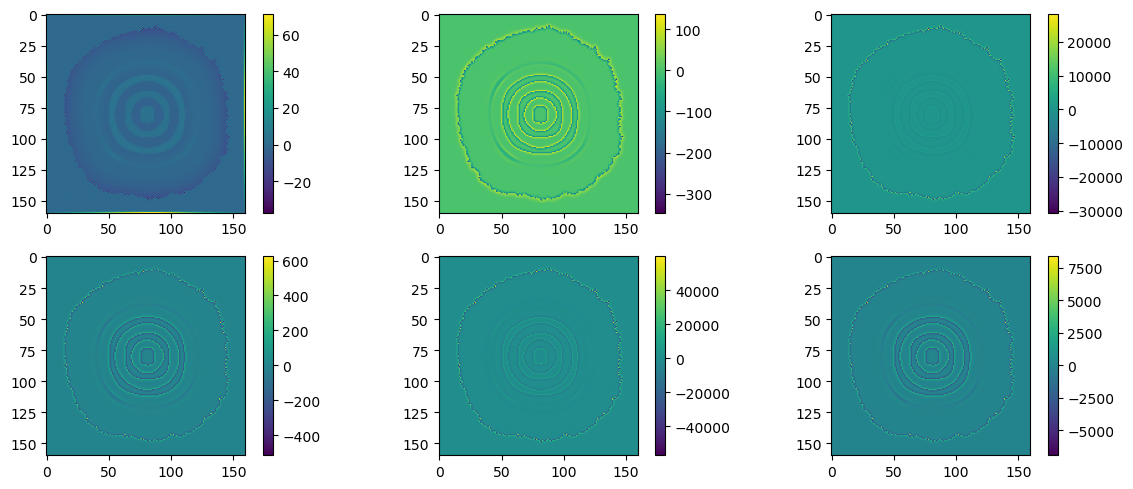

In [10]:
c_xx =  np.array([[ dxdy  * second_order_derivatives((x_size,y_size), data[c, ..., t])[0] 
                        for t in range(data.shape[3])]
                        for c in range(data.shape[0])
                       ])
c_xx = np.einsum("ctij -> cijt", c_xx)
c_yy = np.array([[ dxdy * second_order_derivatives((x_size,y_size), data[c, ..., t])[1] 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_yy = np.einsum("ctij -> cijt", c_yy)

# c_t = np.array([[(data_time[c, ..., t+1] -  data_time[c, ..., t])/(t_star_time[t+1] - t_star_time[t])
#                     for t in range(data.shape[3])]
#                     for c in range(data.shape[0])
#                    ])
# c_t = np.einsum("ctij -> cijt", c_t)

plt.figure(figsize=(12, 5))
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.imshow((c_xx[i,:, : , -1] + c_yy[i,:, : , -1]))
    plt.colorbar()
plt.tight_layout();plt.show()


In [11]:
c_xx.shape

(6, 160, 160, 1)

In [12]:
data.shape

(6, 160, 160, 1)

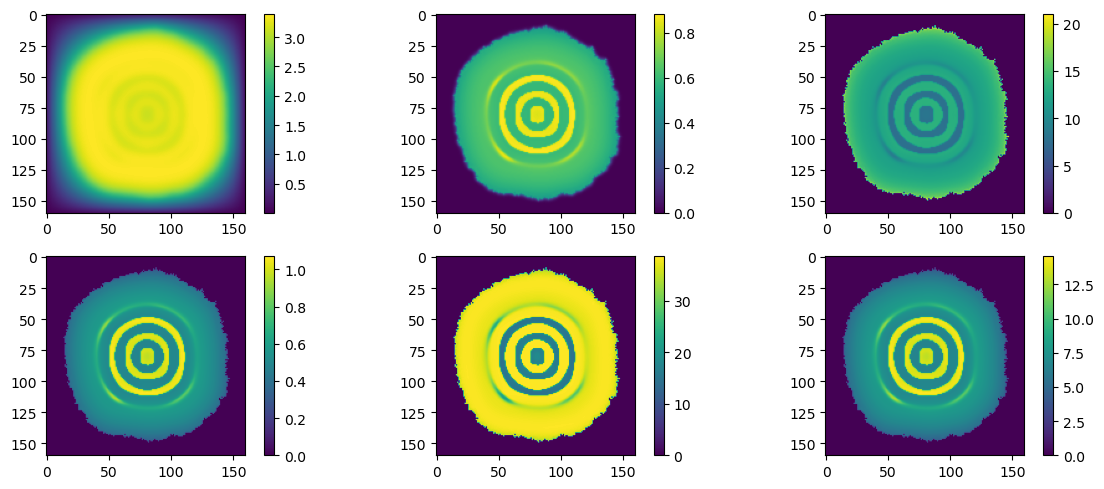

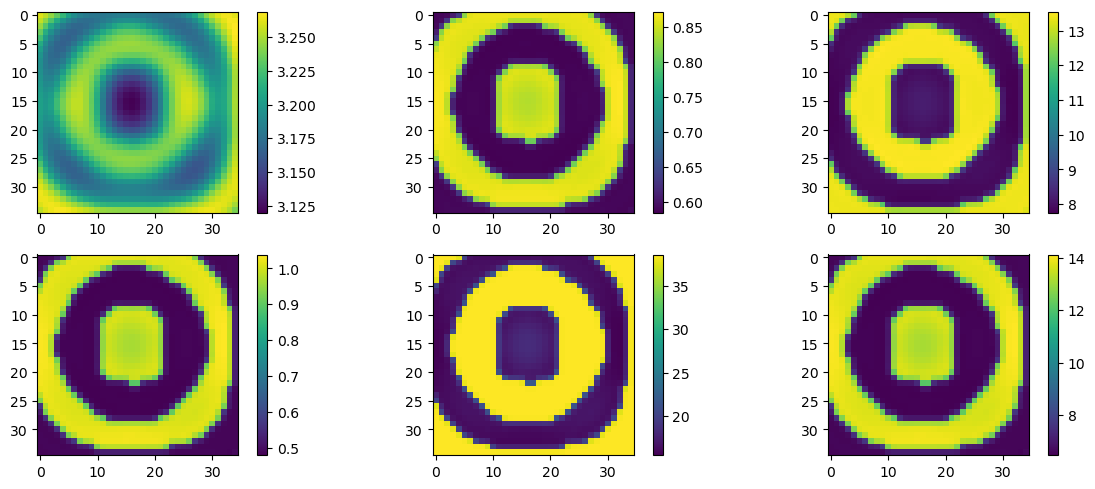

In [13]:
A = data[0, :, :, -1]
B = data[1, :, :, -1]
C = data[2, :, :, -1]
D = data[3, :, :, -1]
E = data[4, :, :, -1]
F = data[5, :, :, -1]

def activate(x, km, n=2):
    act = 1 / (1 + (km / (x + 1e-20)) ** (n))
    return act

def inhibit(x, km, n=2):
    inh = 1 / (1 + (x / (km + 1e-20)) ** (n))
    return inh

params = df_params.loc[ID, :]
DA = params.DA    
DB = params.DB
bA = params.bA
bB = params.bB
bC = params.bC
bD = params.bD
bE = params.bE
bF = params.bF
VA = params.VA
VB = params.VB
VC = params.VC
VD = params.VD
VE = params.VE
VF = params.VF
Kab = params.Kab
Kbd = params.Kbd
Kce = params.Kce
Kda = params.Kda
Keb = params.Keb
Kee = params.Kee
Kfe = params.Kfe
muASV = params.muASV
muLVA = params.muLVA
nab = params.nab
nbd = params.nbd
nce = params.nce
nda = params.nda
nfe = params.nfe
neb = params.neb
nee = params.nee

A_rhs = DA * (c_xx[0, :, :, 0] + c_yy[0, :, :, 0])# - u_t
B_rhs = DB * (c_xx[1, :, :, 0] + c_yy[1, :, :, 0])# - v_t

f_A =  - bA - VA * inhibit(D, Kda, nda) + muASV * A - A_rhs
f_B =  - bB - VB * activate(A, Kab, nab) * inhibit(E, Keb, neb) + muASV * B - B_rhs
f_C =  - bC - VC * inhibit(D, Kda, nda) + muLVA * C
f_D =  - bD - VD * activate(B, Kbd, nbd) + muLVA * D
f_E =  - bE - VE * inhibit(C, Kce, nce) * inhibit(F, Kfe, nfe) * activate(E, Kee, nee) + muLVA * E
f_F =  - bF - VF * activate(B, Kbd, nbd) + muLVA * F

c_t = np.stack([f_A, f_B, f_C, f_D, f_E, f_F])[:,:,:, np.newaxis]

plt.figure(figsize=(12, 5))
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.imshow(data[i, :, :, -1])
    plt.colorbar()
plt.tight_layout();plt.show()
plt.figure(figsize=(12, 5))
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.imshow(data[i, x_slice, y_slice, -1])
    plt.colorbar()
plt.tight_layout();plt.show()

In [14]:
c_xx.shape

(6, 160, 160, 1)

In [15]:
c_restricted = data[:, x_slice, y_slice, :].copy()
c_xx_restricted = c_xx[:, x_slice, y_slice, :].copy()
c_yy_restricted = c_yy[:, x_slice, y_slice, :].copy() 
c_t_restricted = c_t[:, x_slice, y_slice, :].copy()

    
model_params = {'training_data_size': x_size*y_size*T,
                'pde_data_size': x_size*y_size*T,
                'derivatives':[c_xx, c_yy, c_t], 
                'signal_to_noise':0.0,
                'shuffle':False,
                'idx_data':indices_sub.flatten()}


dataset = create_dataset_multi_nodes(data, t_star, N, 1, L, **model_params)
lb = dataset['lb']#[0:2]
#Since there are just one time step, we set the lb of T equal to zero
lb[-1] = 0.0
ub = dataset['ub']#[0:2]
obs_X = np.float32(dataset['obs_input'])#[:, 0:2])
obs_Y = np.float32(dataset['obs_output'])
#pde_X = np.float32(dataset['pde'])
ders_xx = np.float32(dataset['ders'][:, 0, :])
ders_yy = np.float32(dataset['ders'][:, 1, :])
ders_t = np.float32(dataset['ders'][:, 2, :])

In [16]:
A.shape

(160, 160)

In [17]:
obs_X.shape

(1225, 3)

In [18]:
def gen_series():    
    
    for i in range(obs_X.shape[0]):        
        yield obs_X[i,:], obs_Y[i,:], ders_xx[:, i], ders_yy[:, i], ders_t[:, i]    
        
ds = tf.data.Dataset.from_generator(gen_series,
                                    output_types=(tf.float32, tf.float32, tf.float32, tf.float32, tf.float32), 
                                    output_shapes=((obs_X.shape[1],),(obs_Y.shape[1],),
                                                   (ders_xx.shape[0],),(ders_yy.shape[0],),
                                                   (ders_t.shape[0],)))

In [19]:
def clip_by_value_zero_lb(z):
        return tf.clip_by_value(z, 0, 1e10,)
    
class tf_param:
    def __init__(self, name, value=None, is_constant=True):
        self.name = name
        self.value = df_params.loc[ID,:][name]
        if value is None:
            self.value = df_params.loc[ID,:][name]
        else:
            self.value = value
        self.is_constant = is_constant    
    

def create_pinn(layers=[3, 128, 128, 6],
                learning_rate=1e-2,
                w1=1, w2=1, w3=1, w4=1, w5=100, w6=100,w7=1,w8=1,
                DA_val=tf_param("DA"), DB_val=tf_param("DB"),
                bA_val=tf_param("bA"),bB_val=tf_param("bB"),bC_val=tf_param("bC"),
                bD_val=tf_param("bD"),bE_val=tf_param("bE"),bF_val=tf_param("bF"),
                VA_val=tf_param("VA"),VB_val=tf_param("VB"),VC_val=tf_param("VC"),
                VD_val=tf_param("VD"),VE_val=tf_param("VE"),VF_val=tf_param("VF"),
                Kab_val=tf_param("Kab"),Kbd_val=tf_param("Kbd"),Kce_val=tf_param("Kce"),
                Kda_val=tf_param("Kda"),Keb_val=tf_param("Keb"),Kee_val=tf_param("Kee"),
                Kfe_val=tf_param("Kfe"),muASV_val=tf_param("muASV"),muLVA_val=tf_param("muLVA"),
                nab_val=tf_param("nab"),nbd_val=tf_param("nbd"),nce_val=tf_param("nce"),
                nda_val=tf_param("nda"),nfe_val=tf_param("nfe"),neb_val=tf_param("neb"),
                nee_val=tf_param("nee")):    
    #lb = tf.constant([x_range[0], y_range[0], pattern.t_star[0]], dtype=tf.float32)
    #ub =  tf.constant([x_range[-1], y_range[-1], pattern.t_star[-1]], dtype=tf.float32)
    pinn = tu.NN_Scaled(layers, lb, ub, tf.float32)
    #optimizer=keras.optimizers.Adam(learning_rate=1e-2)   
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
    
    def create_tf_var(param, no_clip=False):
        print(f"{param.name}: {param.value}")
        if no_clip:
            return tf.Variable(param.value,
                               dtype=pinn.dtype,
                               name=param.name)
        else:
            return tf.Variable(param.value,
                               dtype=pinn.dtype,
                               name=param.name,
                               constraint=clip_by_value_zero_lb)
    
    DA = create_tf_var(DA_val)    
    DB = create_tf_var(DB_val)
    bA = create_tf_var(bA_val)#
    bB = create_tf_var(bB_val)#
    bC = create_tf_var(bC_val)#
    bD = create_tf_var(bD_val)#
    bE = create_tf_var(bE_val)#
    bF = create_tf_var(bF_val)#
    VA = create_tf_var(VA_val)
    VB = create_tf_var(VB_val)
    VC = create_tf_var(VC_val)
    VD = create_tf_var(VD_val)
    VE = create_tf_var(VE_val)
    VF = create_tf_var(VF_val)
    Kab = create_tf_var(Kab_val)
    Kbd = create_tf_var(Kbd_val)
    Kce = create_tf_var(Kce_val)
    Kda = create_tf_var(Kda_val)
    Keb = create_tf_var(Keb_val)
    Kee = create_tf_var(Kee_val)
    Kfe = create_tf_var(Kfe_val)
    muASV = create_tf_var(muASV_val)
    muLVA = create_tf_var(muLVA_val)
    nab = create_tf_var(nab_val)
    nbd = create_tf_var(nbd_val)
    nce = create_tf_var(nce_val)
    nda = create_tf_var(nda_val)
    nfe = create_tf_var(nfe_val)
    neb = create_tf_var(neb_val)
    nee = create_tf_var(nee_val)
                    
    w1 = tf.Variable(w1,dtype=pinn.dtype,name="w1")
    w2 = tf.Variable(w2,dtype=pinn.dtype,name="w2")
    w3 = tf.Variable(w3,dtype=pinn.dtype,name="w3")
    w4 = tf.Variable(w4,dtype=pinn.dtype,name="w4")
    w5 = tf.Variable(w5,dtype=pinn.dtype,name="w5")
    w6 = tf.Variable(w6,dtype=pinn.dtype,name="w6")
    w7 = tf.Variable(w7,dtype=pinn.dtype,name="w7")
    w8 = tf.Variable(w8,dtype=pinn.dtype,name="w8")
                        
    def as_tuple(val, param):
        if val.is_constant:
            return ()
        else:
            return (param,)
    
    
    params_trainable =(
                      as_tuple(DA_val, DA)
                    + as_tuple(DB_val, DB)
                    + as_tuple(bA_val, bA)
                    + as_tuple(bB_val, bB)
                    + as_tuple(bC_val, bC)
                    + as_tuple(bD_val, bD)
                    + as_tuple(bE_val, bE)
                    + as_tuple(bF_val, bF)
                    + as_tuple(VA_val, VA)
                    + as_tuple(VB_val, VB)
                    + as_tuple(VC_val, VC)
                    + as_tuple(VD_val, VD)
                    + as_tuple(VE_val, VE)
                    + as_tuple(VF_val, VF)
                    + as_tuple(Kab_val, Kab)
                    + as_tuple(Kbd_val, Kbd)
                    + as_tuple(Kce_val, Kce)
                    + as_tuple(Kda_val, Kda)
                    + as_tuple(Keb_val, Keb)
                    + as_tuple(Kee_val, Kee)
                    + as_tuple(Kfe_val, Kfe)
                    + as_tuple(muASV_val, muASV)
                    + as_tuple(muLVA_val, muLVA)
                    + as_tuple(nab_val, nab)
                    + as_tuple(nbd_val, nbd)
                    + as_tuple(nce_val, nce)
                    + as_tuple(nda_val, nda)
                    + as_tuple(nfe_val, nfe)
                    + as_tuple(neb_val, neb)
                    + as_tuple(nee_val, nee)
                   )

    @tf.function
    def train_step_inverse(elements):
        with tf.GradientTape(persistent=True) as tape: 
            H = elements[0]
            tape.watch(H)
            trainables = pinn.trainable_variables + params_trainable


            with tf.GradientTape(persistent=True) as tape2:             
                tape2.watch(H)

                outputs = pinn.net(H)
                Ag = tf.squeeze(outputs[:, 0])
                Bg = tf.squeeze(outputs[:, 1])
#                 Cg = tf.squeeze(outputs[:, 2])
#                 Dg = tf.squeeze(outputs[:, 3])
#                 Eg = tf.squeeze(outputs[:, 4])
#                 Fg = tf.squeeze(outputs[:, 5])

                grad_A = tape2.gradient(Ag, H)
                A_x = grad_A[:, 0]
                A_y = grad_A[:, 1]

                grad_B = tape2.gradient(Bg, H)
                B_x = grad_B[:, 0]
                B_y = grad_B[:, 1]


            grad_A_x = tape.gradient(A_x, H)
            A_xx = grad_A_x[:, 0]
            grad_A_y = tape.gradient(A_y, H)
            A_yy = grad_A_y[:, 1]
            grad_B_x = tape.gradient(B_x, H)
            B_xx = grad_B_x[:, 0]
            grad_B_y = tape.gradient(B_y, H)
            B_yy = grad_B_y[:, 1]

            A = tf.squeeze(elements[1][:, 0])
            B = tf.squeeze(elements[1][:, 1])
            C = tf.squeeze(elements[1][:, 2])
            D = tf.squeeze(elements[1][:, 3])
            E = tf.squeeze(elements[1][:, 4])
            F = tf.squeeze(elements[1][:, 5]) 

            act_A_xx = elements[2][:, 0]
            act_B_xx = elements[2][:, 1]
            act_A_yy = elements[3][:, 0]
            act_B_yy = elements[3][:, 1]

    #         act_A_t = elements[4][:, 0]
    #         act_B_t = elements[4][:, 1]
    #         act_C_t = elements[4][:, 2]
    #         act_D_t = elements[4][:, 3]
    #         act_E_t = elements[4][:, 4]
    #         act_F_t = elements[4][:, 5]            

            def activate(x, km, n=2):
                act = 1 / (1 + (km / (x + 1e-20)) ** (n))
                return act

            def inhibit(x, km, n=2):
                inh = 1 / (1 + (x / (km + 1e-20)) ** (n))
                return inh

            A_rhs = DA * (A_xx + A_yy)# - u_t
            B_rhs = DB * (B_xx + B_yy)# - v_t

            f_A =  -bA -VA * inhibit(D, Kda, nda) + muASV * A - A_rhs
            f_B =  -bB -VB * activate(A, Kab, nab) * inhibit(E, Keb, neb) + muASV * B - B_rhs
            f_C =  -bC -VC * inhibit(D, Kda, nda) + muLVA * C
            f_D =  -bD -VD * activate(B, Kbd, nbd) + muLVA * D
            f_E =  -bE -VE * inhibit(C, Kce, nce) * inhibit(F, Kfe, nfe) * activate(E, Kee, nee) + muLVA * E
            f_F =  -bF -VF * activate(B, Kbd, nbd) + muLVA * F
    #         f_C =  -act_C_t - bC - VC * inhibit(D, Kda, nda) + muLVA * C
    #         f_D =  -act_D_t - bD - VD * activate(B, Kbd, nbd) + muLVA * D
    #         f_E =  -act_E_t - bE - VE * inhibit(C, Kce, nce) * inhibit(F, Kfe, nfe) * activate(E, Kee, nee) + muLVA * E
    #         f_F =  -act_F_t - bF - VF * activate(B, Kbd, nbd) + muLVA * F

            l2_res_A = tf.reduce_sum(f_A**2)
            l2_res_B = tf.reduce_sum(f_B**2)
            l2_res_C = tf.reduce_sum(f_C**2)
            l2_res_D = tf.reduce_sum(f_D**2)
            l2_res_E = tf.reduce_sum(f_E**2)
            l2_res_F = tf.reduce_sum(f_F**2)

            act_A_rhs = DA*(act_A_xx + act_A_yy) #- act_A_t
            act_B_rhs = DB*(act_B_xx + act_B_yy) #- act_B_t

            l2_res_A_rhs = tf.reduce_sum((A_rhs-act_A_rhs)**2)
            l2_res_B_rhs = tf.reduce_sum((B_rhs-act_B_rhs)**2)


            l2 = (w1*l2_res_A + w2*l2_res_B + w3*l2_res_C + w4*l2_res_D + 
                  w5*l2_res_E + w6*l2_res_F +  
                  w7*l2_res_A_rhs + w8*l2_res_B_rhs)
            #l2 = l2_res_A + l2_res_B  + l2_res_A_rhs + l2_res_B_rhs
            # l2 = l2_res_A_rhs + l2_res_B_rhs

        grads = tape.gradient(l2, trainables)
        optimizer.apply_gradients(zip(grads, trainables))
        return (l2_res_A, l2_res_B, l2_res_C, l2_res_D, l2_res_E, l2_res_F,  
                l2_res_A_rhs, l2_res_B_rhs)
    
    names = ['l2_res_A', 'l2_res_B', 'l2_res_C', 'l2_res_D', 'l2_res_E', 'l2_res_F',  
            'l2_res_A_rhs', 'l2_res_B_rhs']

    def print_callback(printer, losses, epoch):

        printer(f"at epoch {epoch:d}, total loss: {np.sum(losses)}")
        printer(", ".join([f"{n}: {v:.8f}" for n,v in zip(names, losses)]))         
        printer(", ".join([f"{par.name}: {par.numpy()}" for par in params_trainable]))
    
    return (pinn, optimizer, train_step_inverse,params_trainable, names, print_callback,
            w1, w2, w3, w4, w5, w6, w7, w8)

In [20]:
(pinn1, optimizer1, train_step_inverse1,params_trainable1,names, print_callback1,
w1, w2, w3, w4, w5, w6, w7, w8) = create_pinn(learning_rate=1e-2,
bA_val=tf_param("bA", 1, False),bB_val=tf_param("bB", 1, False),bC_val=tf_param("bC", 1, False),
bD_val=tf_param("bD", 1, False),bE_val=tf_param("bE", 1, False),bF_val=tf_param("bF", 1, False),
VA_val=tf_param("VA", 1, False),VB_val=tf_param("VB", 1, False),VC_val=tf_param("VC", 1, False),
VD_val=tf_param("VD", 1, False),VE_val=tf_param("VE", 1, False),VF_val=tf_param("VF", 1, False),
w1=1, w2=1, w3=1, w4=1, w5=1000, w6=1000, w7=1, w8=1
)

(bA, bB, bC, bD, bE, bF, VA, VB, VC, VD, VE, VF) = params_trainable1

DA: 1.0
DB: 0.001
bA: 1
bB: 1
bC: 1
bD: 1
bE: 1
bF: 1
VA: 1
VB: 1
VC: 1
VD: 1
VE: 1
VF: 1
Kab: 112.03598370729861
Kbd: 4.693803436565611
Kce: 0.9930030959145896
Kda: 0.2699281477606056
Keb: 45.269302324109745
Kee: 0.563496304565512
Kfe: 10.08286680374087
muASV: 4.247713917996289
muLVA: 1.4288264760159275
nab: 1.0
nbd: 2.0
nce: 1.0
nda: 1.0
nfe: 4.0
neb: 4.0
nee: 4.0


In [21]:
epochs=50000+1
params_est = np.zeros((epochs, 12))

def epoch_callback1(epoch, loss_samples, index):
    params_est[epoch, : ] = (bA.numpy(), bB.numpy(), bC.numpy(), 
                             bD.numpy(), bE.numpy(), bF.numpy(),
                             VA.numpy(), VB.numpy(), VC.numpy(),
                             VD.numpy(), VE.numpy(), VF.numpy()
                            )

In [22]:
obs_X.shape

(1225, 3)

In [23]:
losses1 = tu.train(epochs=epochs,
                  batch_size=1225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 8,
                  print_interval=500,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback1,
                  epoch_callback=epoch_callback1,
                  stop_condition=None)



Start of epoch 0
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-03-02 12:29:51.946581: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-02 12:29:51.994175: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f678800bba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-02 12:29:51.994256: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-03-02 12:29:52.003111: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-02 12:29:52.448081: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


at epoch 0, total loss: 2795029.244898081
l2_res_A: 186903.39062500, l2_res_B: 5587.23339844, l2_res_C: 249534.18750000, l2_res_D: 151.22406006, l2_res_E: 2086460.12500000, l2_res_F: 254167.31250000, l2_res_A_rhs: 12221.77343750, l2_res_B_rhs: 3.99837708
bA:0: 1.010000228881836, bB:0: 1.010000228881836, bC:0: 1.010000228881836, bD:0: 1.010000228881836, bE:0: 1.010000228881836, bF:0: 1.010000228881836, VA:0: 1.010000228881836, VB:0: 1.010000228881836, VC:0: 1.010000228881836, VD:0: 1.010000228881836, VE:0: 1.010000228881836, VF:0: 1.010000228881836
Time taken: 9.83s

Start of epoch 500
at epoch 500, total loss: 1893513.3513679504
l2_res_A: 15875.42578125, l2_res_B: 251.61088562, l2_res_C: 94040.52343750, l2_res_D: 116.69761658, l2_res_E: 1639881.25000000, l2_res_F: 125409.32812500, l2_res_A_rhs: 17902.74218750, l2_res_B_rhs: 35.77333450
bA:0: 5.0116047859191895, bB:0: 2.877868413925171, bC:0: 5.448878765106201, bD:0: 0.9347131848335266, bE:0: 5.856712818145752, bF:0: 5.561485290527344, 


Start of epoch 7000
at epoch 7000, total loss: 282375.6231704522
l2_res_A: 780.27990723, l2_res_B: 61.46051788, l2_res_C: 3222.29443359, l2_res_D: 0.01685865, l2_res_E: 252371.07812500, l2_res_F: 24639.77734375, l2_res_A_rhs: 1245.73925781, l2_res_B_rhs: 54.97672653
bA:0: 5.613284587860107, bB:0: 2.312483549118042, bC:0: 6.6379289627075195, bD:0: 0.02100186236202717, bE:0: 37.3038444519043, bF:0: 13.45748233795166, VA:0: 26.936491012573242, VB:0: 33.865055084228516, VC:0: 30.277971267700195, VD:0: 43.78109359741211, VE:0: 51.96617889404297, VF:0: 47.19066619873047
Time taken: 21.83s

Start of epoch 7500
at epoch 7500, total loss: 278678.47122276446
l2_res_A: 647.07092285, l2_res_B: 55.13511276, l2_res_C: 2426.32250977, l2_res_D: 0.00185860, l2_res_E: 250236.09375000, l2_res_F: 24222.68554688, l2_res_A_rhs: 1039.77221680, l2_res_B_rhs: 51.38930511
bA:0: 4.838196277618408, bB:0: 2.2146739959716797, bC:0: 5.757640838623047, bD:0: 0.013610291294753551, bE:0: 37.177696228027344, bF:0: 13.3


Start of epoch 14000
at epoch 14000, total loss: 235655.61093614684
l2_res_A: 100.94459534, l2_res_B: 9.82358742, l2_res_C: 0.01239470, l2_res_D: 0.00010032, l2_res_E: 216449.37500000, l2_res_F: 18975.77148438, l2_res_A_rhs: 109.24196625, l2_res_B_rhs: 10.44180775
bA:0: 0.24235789477825165, bB:0: 0.9356168508529663, bC:0: 0.009037194773554802, bD:0: 0.010002627037465572, bE:0: 34.50065612792969, bF:0: 11.803504943847656, VA:0: 45.9214973449707, VB:0: 94.10504150390625, VC:0: 53.67329406738281, VD:0: 44.24029541015625, VE:0: 117.85478210449219, VF:0: 115.50194549560547
Time taken: 21.59s

Start of epoch 14500
at epoch 14500, total loss: 232672.22792036703
l2_res_A: 94.16803741, l2_res_B: 8.03693676, l2_res_C: 0.01239203, l2_res_D: 0.00010380, l2_res_E: 213865.35937500, l2_res_F: 18597.74414062, l2_res_A_rhs: 98.15895081, l2_res_B_rhs: 8.74798393
bA:0: 0.22506603598594666, bB:0: 0.8438408374786377, bC:0: 0.008906125091016293, bD:0: 0.010035550221800804, bE:0: 34.29310989379883, bF:0: 11


Start of epoch 21000
at epoch 21000, total loss: 195874.3477014603
l2_res_A: 58.68531036, l2_res_B: 1.00188613, l2_res_C: 0.01239156, l2_res_D: 0.00061742, l2_res_E: 181716.60937500, l2_res_F: 14035.81445312, l2_res_A_rhs: 61.16018677, l2_res_B_rhs: 1.06348109
bA:0: 0.15664279460906982, bB:0: 0.05417823791503906, bC:0: 0.008828728459775448, bD:0: 0.010420260950922966, bE:0: 31.606863021850586, bF:0: 10.152636528015137, VA:0: 46.20927047729492, VB:0: 132.93186950683594, VC:0: 53.674015045166016, VD:0: 44.24071502685547, VE:0: 187.00318908691406, VF:0: 184.0331573486328
Time taken: 22.13s

Start of epoch 21500
at epoch 21500, total loss: 193170.4266466513
l2_res_A: 51.10577774, l2_res_B: 1.01131678, l2_res_C: 0.01239715, l2_res_D: 0.00010033, l2_res_E: 179353.28125000, l2_res_F: 13712.21582031, l2_res_A_rhs: 51.74544525, l2_res_B_rhs: 1.05453908
bA:0: 0.1486416906118393, bB:0: 0.045326150953769684, bC:0: 0.008828134275972843, bD:0: 0.009997670538723469, bE:0: 31.400554656982422, bF:0: 1


Start of epoch 28000
at epoch 28000, total loss: 159993.82933098215
l2_res_A: 39.89604950, l2_res_B: 0.89525729, l2_res_C: 0.01246728, l2_res_D: 0.00010775, l2_res_E: 150057.90625000, l2_res_F: 9854.03320312, l2_res_A_rhs: 40.15644455, l2_res_B_rhs: 0.92955148
bA:0: 0.09787614643573761, bB:0: 0.03540833666920662, bC:0: 0.009057624265551567, bD:0: 0.009953426197171211, bE:0: 28.720781326293945, bF:0: 8.508363723754883, VA:0: 46.42327880859375, VB:0: 133.65078735351562, VC:0: 53.67424011230469, VD:0: 44.24024963378906, VE:0: 256.0634460449219, VF:0: 252.30001831054688
Time taken: 21.95s

Start of epoch 28500
at epoch 28500, total loss: 157598.80653295893
l2_res_A: 46.81763077, l2_res_B: 1.01438749, l2_res_C: 0.01243750, l2_res_D: 0.00010032, l2_res_E: 147914.29687500, l2_res_F: 9584.04101562, l2_res_A_rhs: 51.58311462, l2_res_B_rhs: 1.04097164
bA:0: 0.12718325853347778, bB:0: 0.036015912890434265, bC:0: 0.00872485525906086, bD:0: 0.010001852177083492, bE:0: 28.51460838317871, bF:0: 8.39


Start of epoch 35000
at epoch 35000, total loss: 127946.83319757505
l2_res_A: 34.30030441, l2_res_B: 0.74584907, l2_res_C: 0.01335708, l2_res_D: 0.00010032, l2_res_E: 121450.64843750, l2_res_F: 6425.83886719, l2_res_A_rhs: 34.51959991, l2_res_B_rhs: 0.76668209
bA:0: 0.08016030490398407, bB:0: 0.025538651272654533, bC:0: 0.009635592810809612, bD:0: 0.01000273134559393, bE:0: 25.83731460571289, bF:0: 6.8723225593566895, VA:0: 46.47767639160156, VB:0: 134.01654052734375, VC:0: 53.67481994628906, VD:0: 44.24029541015625, VE:0: 325.0636901855469, VF:0: 320.2142639160156
Time taken: 21.66s

Start of epoch 35500
at epoch 35500, total loss: 125789.04582847925
l2_res_A: 27.46553230, l2_res_B: 0.72517115, l2_res_C: 0.01239159, l2_res_D: 0.00010043, l2_res_E: 119522.93750000, l2_res_F: 6209.52441406, l2_res_A_rhs: 27.64505196, l2_res_B_rhs: 0.73566699
bA:0: 0.0773496925830841, bB:0: 0.024387899786233902, bC:0: 0.008842980489134789, bD:0: 0.009983382187783718, bE:0: 25.631324768066406, bF:0: 6.75


Start of epoch 42000
at epoch 42000, total loss: 99790.69563480798
l2_res_A: 56.06494141, l2_res_B: 0.85260451, l2_res_C: 0.01241960, l2_res_D: 0.00010032, l2_res_E: 95933.76562500, l2_res_F: 3746.10302734, l2_res_A_rhs: 53.03602219, l2_res_B_rhs: 0.86089444
bA:0: 0.11188157647848129, bB:0: 0.031846798956394196, bC:0: 0.00896729901432991, bD:0: 0.010002202354371548, bE:0: 22.96198272705078, bF:0: 5.249776840209961, VA:0: 46.36883544921875, VB:0: 133.7507781982422, VC:0: 53.67415237426758, VD:0: 44.24029541015625, VE:0: 393.86968994140625, VF:0: 387.5944519042969
Time taken: 21.66s

Start of epoch 42500
at epoch 42500, total loss: 97882.00106398288
l2_res_A: 35.09902191, l2_res_B: 0.75691277, l2_res_C: 0.01239514, l2_res_D: 0.00010036, l2_res_E: 94226.62500000, l2_res_F: 3583.08666992, l2_res_A_rhs: 35.63412094, l2_res_B_rhs: 0.78684294
bA:0: 0.09997815638780594, bB:0: 0.030770663172006607, bC:0: 0.008794420398771763, bD:0: 0.009960619732737541, bE:0: 22.756643295288086, bF:0: 5.134488


Start of epoch 49000
at epoch 49000, total loss: 75369.22437523617
l2_res_A: 51.56227112, l2_res_B: 1.10490417, l2_res_C: 0.01243766, l2_res_D: 0.00010148, l2_res_E: 73456.70312500, l2_res_F: 1806.55810547, l2_res_A_rhs: 52.14294052, l2_res_B_rhs: 1.14048982
bA:0: 0.1303015649318695, bB:0: 0.04477785900235176, bC:0: 0.008991960436105728, bD:0: 0.009975024498999119, bE:0: 20.09140396118164, bF:0: 3.6486823558807373, VA:0: 46.305599212646484, VB:0: 133.2034912109375, VC:0: 53.674171447753906, VD:0: 44.24026870727539, VE:0: 462.5635986328125, VF:0: 454.0713806152344
Time taken: 21.76s

Start of epoch 49500
at epoch 49500, total loss: 73755.07336761014
l2_res_A: 44.42176819, l2_res_B: 1.06383300, l2_res_C: 0.01241193, l2_res_D: 0.00010053, l2_res_E: 71968.44531250, l2_res_F: 1695.91394043, l2_res_A_rhs: 44.12014389, l2_res_B_rhs: 1.09585714
bA:0: 0.1177590861916542, bB:0: 0.040784914046525955, bC:0: 0.008780076168477535, bD:0: 0.01001367624849081, bE:0: 19.886741638183594, bF:0: 3.5354681

In [24]:
epochs2=100000+1
params_est2 = np.zeros((epochs2, 12))

def epoch_callback2(epoch, loss_samples, index):
    params_est2[epoch, : ] = (bA.numpy(), bB.numpy(), bC.numpy(), 
                             bD.numpy(), bE.numpy(), bF.numpy(),
                             VA.numpy(), VB.numpy(), VC.numpy(),
                             VD.numpy(), VE.numpy(), VF.numpy()
                            )

In [25]:
losses2 = tu.train(epochs=epochs2,
                  batch_size=1225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 8,
                  print_interval=1000,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback1,
                  epoch_callback=epoch_callback2,
                  stop_condition=None)



Start of epoch 0
at epoch 0, total loss: 72244.16826227536
l2_res_A: 76.02387238, l2_res_B: 1.09754908, l2_res_C: 0.01239171, l2_res_D: 0.00010181, l2_res_E: 70492.49218750, l2_res_F: 1588.89648438, l2_res_A_rhs: 84.48915100, l2_res_B_rhs: 1.15652442
bA:0: 0.11270125955343246, bB:0: 0.03634585812687874, bC:0: 0.008784781210124493, bD:0: 0.010004563257098198, bE:0: 19.68112564086914, bF:0: 3.422393798828125, VA:0: 46.37113952636719, VB:0: 133.56170654296875, VC:0: 53.67396545410156, VD:0: 44.240299224853516, VE:0: 472.3695373535156, VF:0: 463.4649353027344
Time taken: 0.78s

Start of epoch 1000
at epoch 1000, total loss: 69121.12201320431
l2_res_A: 66.98097229, l2_res_B: 1.04948795, l2_res_C: 0.01240252, l2_res_D: 0.00010181, l2_res_E: 67592.19531250, l2_res_F: 1386.16003418, l2_res_A_rhs: 73.63426208, l2_res_B_rhs: 1.08943987
bA:0: 0.11282455921173096, bB:0: 0.03275179862976074, bC:0: 0.008868989534676075, bD:0: 0.009961412288248539, bE:0: 19.271629333496094, bF:0: 3.197129964828491, 


Start of epoch 14000
at epoch 14000, total loss: 35616.57050818667
l2_res_A: 24.26236343, l2_res_B: 0.82158446, l2_res_C: 0.01243240, l2_res_D: 0.00010032, l2_res_E: 35534.70703125, l2_res_F: 30.81864166, l2_res_A_rhs: 25.11004257, l2_res_B_rhs: 0.83831209
bA:0: 0.0682702511548996, bB:0: 0.025675637647509575, bC:0: 0.00891451258212328, bD:0: 0.010002156719565392, bE:0: 13.970231056213379, bF:0: 0.4849938452243805, VA:0: 46.52983474731445, VB:0: 134.0047607421875, VC:0: 53.674095153808594, VD:0: 44.24030303955078, VE:0: 609.0335693359375, VF:0: 585.4232788085938
Time taken: 43.92s

Start of epoch 15000
at epoch 15000, total loss: 33592.3787141081
l2_res_A: 36.29653931, l2_res_B: 0.99571615, l2_res_C: 0.01239421, l2_res_D: 0.00010032, l2_res_E: 33503.23437500, l2_res_F: 13.64286804, l2_res_A_rhs: 37.16602707, l2_res_B_rhs: 1.03069401
bA:0: 0.1075366884469986, bB:0: 0.03776409849524498, bC:0: 0.008792223408818245, bD:0: 0.010001990012824535, bE:0: 13.564854621887207, bF:0: 0.325823485851


Start of epoch 28000
at epoch 28000, total loss: 12768.247790756926
l2_res_A: 58.24398041, l2_res_B: 1.13790953, l2_res_C: 0.01239193, l2_res_D: 0.00010032, l2_res_E: 12647.08691406, l2_res_F: 0.01876974, l2_res_A_rhs: 60.54435349, l2_res_B_rhs: 1.20337129
bA:0: 0.14662320911884308, bB:0: 0.05325520783662796, bC:0: 0.008816637098789215, bD:0: 0.01000181958079338, bE:0: 8.330410957336426, bF:0: 0.010028200224041939, VA:0: 46.255184173583984, VB:0: 132.72967529296875, VC:0: 53.67399978637695, VD:0: 44.240299224853516, VE:0: 744.010986328125, VF:0: 605.1434326171875
Time taken: 43.62s

Start of epoch 29000
at epoch 29000, total loss: 11620.268876544127
l2_res_A: 75.01591492, l2_res_B: 1.14522982, l2_res_C: 0.01247342, l2_res_D: 0.00021596, l2_res_E: 11469.30175781, l2_res_F: 0.01876971, l2_res_A_rhs: 73.58082581, l2_res_B_rhs: 1.19368911
bA:0: 0.13372652232646942, bB:0: 0.0476558580994606, bC:0: 0.008495350368320942, bD:0: 0.010312208905816078, bE:0: 7.932180404663086, bF:0: 0.0100201917


Start of epoch 42000
at epoch 42000, total loss: 1585.075049197767
l2_res_A: 21.56978416, l2_res_B: 0.95279300, l2_res_C: 0.01239164, l2_res_D: 0.00197855, l2_res_E: 1539.71911621, l2_res_F: 0.01876978, l2_res_A_rhs: 21.85015488, l2_res_B_rhs: 0.95006096
bA:0: 0.07433236390352249, bB:0: 0.030561866238713264, bC:0: 0.008832705207169056, bD:0: 0.011378713883459568, bE:0: 2.8988699913024902, bF:0: 0.010124881751835346, VA:0: 46.512813568115234, VB:0: 133.8378448486328, VC:0: 53.674015045166016, VD:0: 44.241676330566406, VE:0: 873.972900390625, VF:0: 605.1434936523438
Time taken: 44.14s

Start of epoch 43000
at epoch 43000, total loss: 1228.982621521689
l2_res_A: 23.97688866, l2_res_B: 0.92919254, l2_res_C: 0.01244168, l2_res_D: 0.00010534, l2_res_E: 1177.26403809, l2_res_F: 0.01876965, l2_res_A_rhs: 25.83432388, l2_res_B_rhs: 0.94686168
bA:0: 0.07144207507371902, bB:0: 0.030616700649261475, bC:0: 0.009015482850372791, bD:0: 0.00992344319820404, bE:0: 2.5333025455474854, bF:0: 0.010034590


Start of epoch 57000
at epoch 57000, total loss: 110.0660890052095
l2_res_A: 54.04257965, l2_res_B: 1.25916648, l2_res_C: 0.01239237, l2_res_D: 0.00386442, l2_res_E: 0.28413764, l2_res_F: 0.01877268, l2_res_A_rhs: 53.09507370, l2_res_B_rhs: 1.35010207
bA:0: 0.1276797205209732, bB:0: 0.054552461951971054, bC:0: 0.008855173364281654, bD:0: 0.011339209042489529, bE:0: 0.0, bF:0: 0.009915872476994991, VA:0: 46.32594299316406, VB:0: 132.7139434814453, VC:0: 53.67403030395508, VD:0: 44.24163055419922, VE:0: 943.3751831054688, VF:0: 605.1432495117188
Time taken: 43.80s

Start of epoch 58000
at epoch 58000, total loss: 103.6366104237095
l2_res_A: 49.25094986, l2_res_B: 1.18567598, l2_res_C: 0.01239355, l2_res_D: 0.00029103, l2_res_E: 0.28413731, l2_res_F: 0.01879189, l2_res_A_rhs: 51.61983871, l2_res_B_rhs: 1.26453209
bA:0: 0.11091810464859009, bB:0: 0.04739005118608475, bC:0: 0.008861606940627098, bD:0: 0.009764041751623154, bE:0: 0.0, bF:0: 0.009903216734528542, VA:0: 46.39927673339844, VB:


Start of epoch 72000
at epoch 72000, total loss: 181.33721430400328
l2_res_A: 84.97056580, l2_res_B: 1.80980158, l2_res_C: 0.01241942, l2_res_D: 0.00010032, l2_res_E: 0.28413796, l2_res_F: 0.01877110, l2_res_A_rhs: 92.33001709, l2_res_B_rhs: 1.91140103
bA:0: 0.19174686074256897, bB:0: 0.055028967559337616, bC:0: 0.008702792227268219, bD:0: 0.010000929236412048, bE:0: 0.0, bF:0: 0.010039721615612507, VA:0: 46.1119499206543, VB:0: 132.81399536132812, VC:0: 53.673885345458984, VD:0: 44.240291595458984, VE:0: 943.3751220703125, VF:0: 605.1434326171875
Time taken: 43.56s

Start of epoch 73000
at epoch 73000, total loss: 172.45571492916497
l2_res_A: 84.10729980, l2_res_B: 1.75526094, l2_res_C: 0.01241734, l2_res_D: 0.00010032, l2_res_E: 0.28413793, l2_res_F: 0.01877575, l2_res_A_rhs: 84.48590851, l2_res_B_rhs: 1.79181433
bA:0: 0.16937923431396484, bB:0: 0.048057153820991516, bC:0: 0.008720573037862778, bD:0: 0.010002299211919308, bE:0: 0.0, bF:0: 0.010098014026880264, VA:0: 46.1816787719726


Start of epoch 87000
at epoch 87000, total loss: 76.41382330744091
l2_res_A: 36.66151047, l2_res_B: 1.36411011, l2_res_C: 0.01239160, l2_res_D: 0.00010675, l2_res_E: 0.28413796, l2_res_F: 0.01876983, l2_res_A_rhs: 36.66119385, l2_res_B_rhs: 1.41160274
bA:0: 0.08450362831354141, bB:0: 0.0402994379401207, bC:0: 0.008841536939144135, bD:0: 0.009951571002602577, bE:0: 0.0, bF:0: 0.010013600811362267, VA:0: 46.46530532836914, VB:0: 133.5030059814453, VC:0: 53.67402648925781, VD:0: 44.2402458190918, VE:0: 943.3751220703125, VF:0: 605.1434326171875
Time taken: 43.50s

Start of epoch 88000
at epoch 88000, total loss: 68.41005792604847
l2_res_A: 32.09070587, l2_res_B: 1.36379826, l2_res_C: 0.01239180, l2_res_D: 0.00010032, l2_res_E: 0.28413633, l2_res_F: 0.01876968, l2_res_A_rhs: 33.22397614, l2_res_B_rhs: 1.41617954
bA:0: 0.07904297858476639, bB:0: 0.04041580110788345, bC:0: 0.008847502060234547, bD:0: 0.010001522488892078, bE:0: 0.0, bF:0: 0.010026538744568825, VA:0: 46.489017486572266, VB:0

In [ ]:
bA:0.01, bB:0.01, bC:0.01, bD:0.01
bE:0.01, bF:0.01, VA:46.733347, VB:134.697819
VC:53.677758, VD:44.231763, VE:943.26562, VF:605.026691,

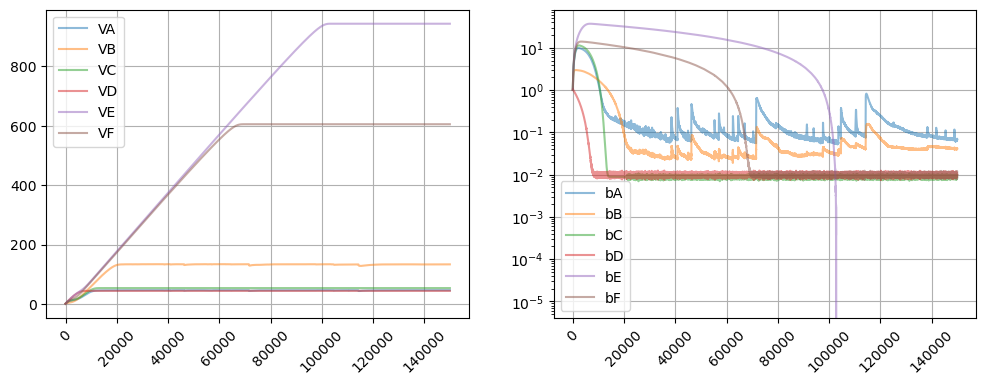

In [31]:
param_name = ["bA", "bB", "bC", "bD", "bE", "bF", "VA", "VB", "VC", "VD", "VE", "VF"]
plt.figure(figsize=(12,4));plt.subplot(121)
for i, n in enumerate(param_name):
    if params_est2[-1,i] > 20:
        plt.plot(np.r_[params_est[:,i], params_est2[:,i]], label=n, alpha=.5)
        
plt.legend();plt.xticks(rotation=45);plt.grid()
plt.subplot(122)
for i, n in enumerate(param_name):
    if params_est2[-1,i] <= 20:
        plt.plot(np.r_[params_est[:,i], params_est2[:,i]], label=n, alpha=.5)
        
plt.legend();plt.xticks(rotation=45);plt.grid();plt.yscale('log');plt.show()

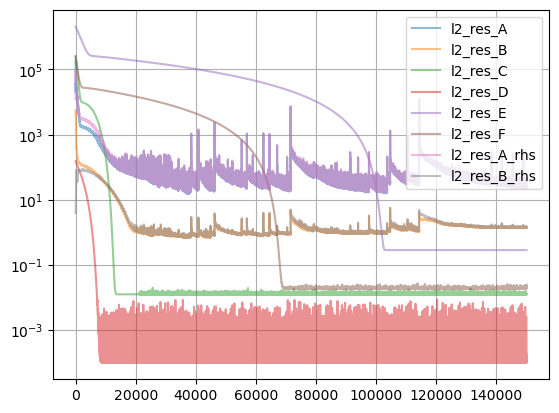

In [33]:
for i, n in enumerate(names):
    plt.plot(np.r_[losses1[:,i],losses2[:,i]], label=n, alpha=.5)
        
plt.legend();plt.grid();plt.yscale('log');plt.show()

In [34]:
@tf.function
def grads(pinn, inputs):    
    with tf.GradientTape(persistent=True) as tape:        
        tape.watch(inputs)      
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(inputs)            
            outputs = pinn.net(inputs)            
        
            Ag = tf.squeeze(outputs[:, 0])
            Bg = tf.squeeze(outputs[:, 1])
            Cg = tf.squeeze(outputs[:, 2])
            Dg = tf.squeeze(outputs[:, 3])
            Eg = tf.squeeze(outputs[:, 4])
            Fg = tf.squeeze(outputs[:, 5])

            grad_A = tape2.gradient(Ag, inputs)
            A_x = grad_A[:, 0]
            A_y = grad_A[:, 1]
            A_t = grad_A[:, 2]

            grad_B = tape2.gradient(Bg, inputs)
            B_x = grad_B[:, 0]
            B_y = grad_B[:, 1]
            B_t = grad_B[:, 2]
            
#             grad_C = tape2.gradient(Cg, inputs)
#             C_t = grad_C[:, 2]
            
#             grad_D = tape2.gradient(Dg, inputs)
#             D_t = grad_D[:, 2]
            
#             grad_E = tape2.gradient(Eg, inputs)
#             E_t = grad_E[:, 2]
            
#             grad_F = tape2.gradient(Fg, inputs)
#             F_t = grad_F[:, 2]
            

        grad_A_x = tape.gradient(A_x, inputs)
        A_xx = grad_A_x[:, 0]
        grad_A_y = tape.gradient(A_y, inputs)
        A_yy = grad_A_y[:, 1]
        grad_B_x = tape.gradient(B_x, inputs)
        B_xx = grad_B_x[:, 0]
        grad_B_y = tape.gradient(B_y, inputs)
        B_yy = grad_B_y[:, 1]
    return (tf.squeeze(Ag), tf.squeeze(A_xx), tf.squeeze(A_yy), tf.squeeze(A_t),
            tf.squeeze(Bg), tf.squeeze(B_xx), tf.squeeze(B_yy), tf.squeeze(B_t),
            tf.squeeze(Cg), 
            tf.squeeze(Dg), 
            tf.squeeze(Eg), 
            tf.squeeze(Fg))                               
#     return (tf.squeeze(Ag), tf.squeeze(A_xx), tf.squeeze(A_yy), tf.squeeze(A_t),
#             tf.squeeze(Bg), tf.squeeze(B_xx), tf.squeeze(B_yy), tf.squeeze(B_t),
#             tf.squeeze(Cg), tf.squeeze(C_t),
#             tf.squeeze(Dg), tf.squeeze(D_t),
#             tf.squeeze(Eg), tf.squeeze(E_t),
#             tf.squeeze(Fg), tf.squeeze(F_t))

def to(arr):
    return arr.numpy().reshape(block_x, block_y)

def plot_state(pinn):
        (A, A_xx, A_yy, A_t,
         B, B_xx, B_yy, B_t,
         C,  D,  E,  F, 
        ) = grads(pinn, obs_X)
        
        A_der = DA*( to(A_xx) + to(A_yy))
        B_der = DB*( to(B_xx) + to(B_yy))

        actual_A_der = DA*( c_xx[0,x_slice, y_slice  , -1] + c_yy[0,x_slice, y_slice  , -1])# - to(u_t2)[-1, ...]
        actual_B_der = DB*( c_xx[1,x_slice, y_slice  , -1] + c_yy[1,x_slice, y_slice  , -1])# - to(v_t2)[-1, ...]
        # X and Y are misoriented
        A_der = A_der
        B_der = B_der
        
        plot_n_im([to(A), c_restricted[0,:, : , -1], to(B), c_restricted[1,:, :  , -1]], 
          ["A", "Actual A", "B", "Actual B"],          
          figsize=(12, 3)); plt.tight_layout()

        A = c_restricted[0,:, : , -1]
        B = c_restricted[1,:, : , -1]

        
        
        plot_n_im([to(A_xx), c_xx[0,x_slice, y_slice , -1], to(A_yy), c_yy[0,x_slice, y_slice  , -1]], 
          ["A_xx", "Actual A_xx", "A_yy", "Actual A_yy"],          
          figsize=(12, 3)); plt.tight_layout()

        plot_n_im([to(B_xx), c_xx[1,x_slice, y_slice  , -1], to(B_yy), c_yy[1,x_slice, y_slice  , -1]],
                  ["B_xx", "Actual B_xx", "B_yy", "Actual B_yy"],          
                  figsize=(12, 3)); plt.tight_layout()
        plot_n_im([to(A_t),  c_t[0,x_slice, y_slice , -1],  to(B_t),  c_t[1,x_slice, y_slice , -1]],
                   ["A_t", "Actual A_t", "B_t", "Actual B_t"],          
                   figsize=(12, 3)); plt.tight_layout()
#         plot_n_im([c_t[0,x_slice, y_slice , -1],   c_t[1,x_slice, y_slice, -1]],
#                    ["Actual A_t",  "Actual B_t"],          
#                    figsize=(12, 3)); plt.tight_layout()
        plot_n_im([A_der,  actual_A_der],
                  ["RHS A", "Actual RHS A"],          
                  figsize=(12, 3)); plt.tight_layout()
        plot_n_im([B_der,  actual_B_der],
                  ["RHS B", "Actual RHS B"],          
                  figsize=(12, 3)); plt.tight_layout()
        plt.show()

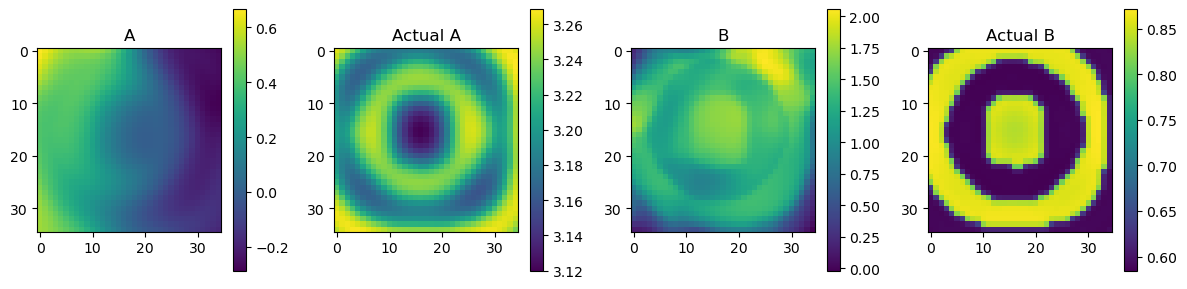

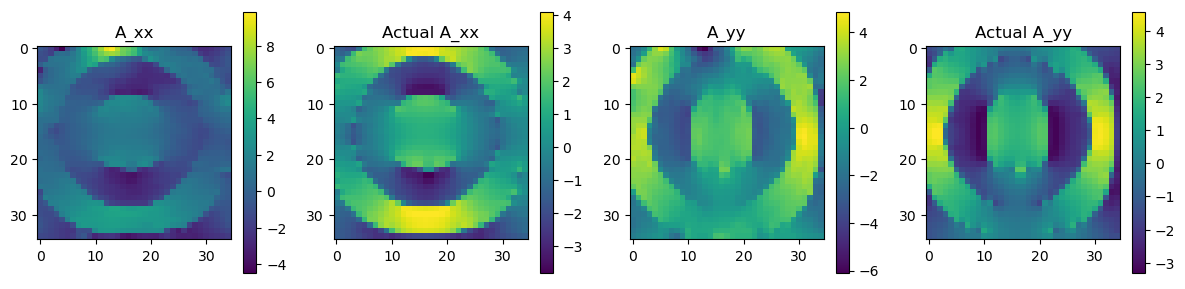

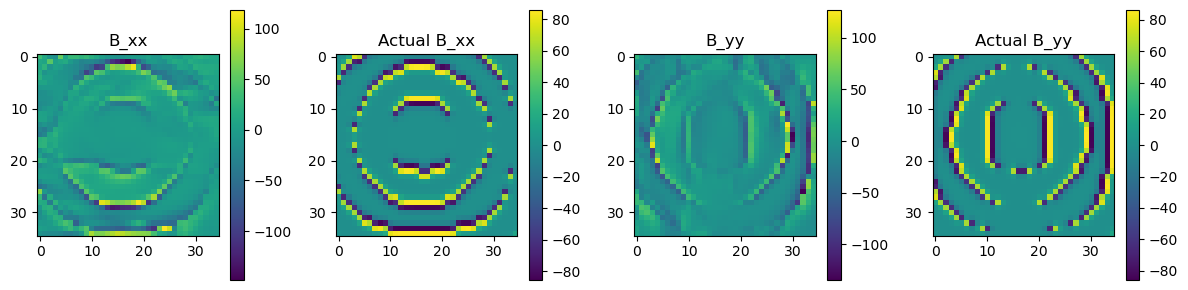

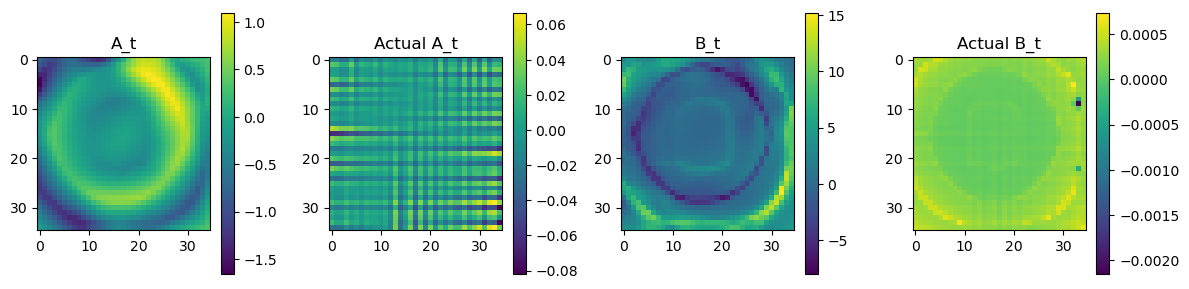

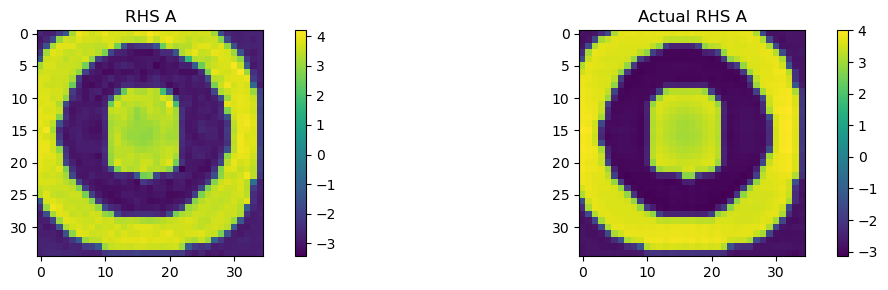

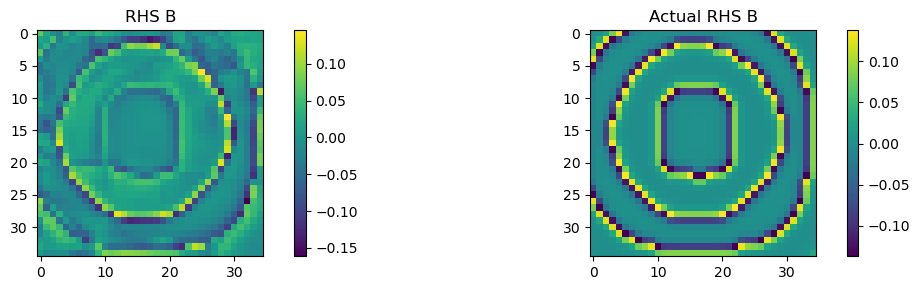

In [35]:
plot_state(pinn1)

In [36]:
(A, A_xx, A_yy, A_t,
         B, B_xx, B_yy, B_t,
         C,  D,  E,  F, 
        ) = grads(pinn1, obs_X)

In [37]:
u_t_act = c_t[0,x_slice, y_slice , -1]
v_t_act = c_t[1,x_slice, y_slice , -1]
print(np.sum(u_t_act**2))
print(np.sum(v_t_act**2))
print(np.sum(ders_t[0, :]**2))
print(np.sum(ders_t[1, :]**2))

0.49224496907994086
6.61899213916773e-05
0.492245
6.6189925e-05


In [38]:
A_der = DA*( to(A_xx) + to(A_yy))
B_der = DB*( to(B_xx) + to(B_yy))

actual_A_der = DA*( c_xx[0,x_slice, y_slice  , -1] + c_yy[0,x_slice, y_slice  , -1])# - to(u_t2)[-1, ...]
actual_B_der = DB*( c_xx[1,x_slice, y_slice  , -1] + c_yy[1,x_slice, y_slice  , -1])# - to(v_t2)[-1, ...]

In [39]:
print(np.sum((A_der-actual_A_der)**2))
print(np.sqrt(np.mean((A_der-actual_A_der)**2)))
print(np.mean(np.abs(A_der-actual_A_der)/np.abs(actual_A_der)))
print(np.sum((B_der-actual_B_der)**2))
print(np.sqrt(np.mean((B_der-actual_B_der)**2)))
print(np.mean(np.abs(B_der-actual_B_der)/np.abs(actual_B_der)))

28.86155912408842
0.15349415763418256
0.037872732225577556
1.4174965251515463
0.034016760876542526
82.81529237708388
